<a href="https://colab.research.google.com/github/dallinmoore/avalanche-forecasting/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Avalanche Danger

Project by Dallin Moore

---
## Details
Class: DATA 5610 - Deep Learning

Assignment: Final Project

Prof.: Dr. Sharad Jones

In [45]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import date
from pathlib import Path
from typing import Dict, List

import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

# CONSTANTS
BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/"


## Fetch SNOTEL Station Data

In [46]:
def fetch_snotel_metadata():
    metadata_url = BASE_URL + "stations"
    params = {
        "stationTriplets": "*:UT:SNTL",
        "returnForecastPointMetadata": "false",
        "returnReservoirMetadata": "false",
        "returnStationElements": "false",
        "activeOnly": "true",
        "durations": "HOURLY",
    }
    response = requests.get(metadata_url, params=params, timeout=30)
    if response.ok:
        return response.json()
    print("Request failed with status code:", response.status_code)
    return []

keys = [
    "stationId",
    "stateCode",
    "networkCode",
    "name",
    "countyName",
    "elevation",
    "latitude",
    "longitude",
    "beginDate"
]

data = fetch_snotel_metadata()
snotel_df = pd.DataFrame([{key: station.get(key, "") for key in keys} for station in data])
snotel_df.head()

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate
0,907,UT,SNTL,Agua Canyon,Kane,8890.0,37.52217,-112.27118,1994-10-01 00:00
1,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775,2022-08-25 00:00
2,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770,2010-10-28 00:00
3,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813,1980-06-18 00:00
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00


### Categorize Stations by Region

In [47]:
region_boundaries = {
    "Logan": [[41.2, -111.9], [42.0, -111.9], [42.0, -111.1], [41.2, -111.1]],
    "Ogden": [[40.8, -112.0], [41.2, -112.0], [41.2, -111.1], [40.8, -111.1]],
    "Salt Lake": [[40.4, -112.0], [40.8, -112.0], [40.8, -111.1], [40.4, -111.1]],
    "Uintas": [[40.3, -111.1], [41.0, -111.1], [41.0, -109.4], [40.3, -109.4]],
    "Provo": [[39.8, -112.0], [40.4, -112.0], [40.4, -111.1], [39.8, -111.1]],
    "Skyline": [[38.9, -111.8], [39.8, -111.8], [39.8, -111.1], [38.9, -111.1]],
    "Moab": [[38.0, -109.8], [39.0, -109.8], [39.0, -108.9], [38.0, -108.9]],
    "Abajos": [[37.5, -109.9], [37.9, -109.9], [37.9, -109.1], [37.5, -109.1]],
    "Southwest": [[37.0, -114.0], [38.5, -114.0], [38.5, -112.5], [37.0, -112.5]],
}

SNOTEL stations that are not in the boundaries, but are within 0.3 degrees (roughly 20 miles) are grouped into that region. So some stations are used by multiple regions and some are not included.

In [48]:
region_shapes = {r: Polygon(c) for r, c in region_boundaries.items()}
_poly_list = list(region_shapes.values())
_region_tree = STRtree(_poly_list)

# Two parallel maps so we handle both pygeos‑style (int indices) *and* Shapely 2.x (clone geoms)
_poly_idx_to_region = {idx: region for idx, region in enumerate(region_shapes)}
_poly_wkb_to_region = {poly.wkb: region for region, poly in region_shapes.items()}

def determine_region(lat, lon, min_distance_threshold=0.1):
    """Return **all** regions whose polygon either contains the point or lies
    within *min_distance_threshold* degrees of it.

    Uses a buffered point when querying the STRtree, so regions whose bounding
    box is within the threshold are considered even if the point itself is
    just outside the box.  Works with both Shapely‑2 (geometries returned) and
    older PyGEOS/Shapely‑1 (integer indices returned).
    """
    pt   = Point(lat, lon)               # (lat, lon) order preserved
    buf  = pt.buffer(min_distance_threshold)  # degrees

    regions = []
    for item in _region_tree.query(buf):  # buffered query widens candidate set
        # Shapely‑1 / PyGEOS ⇒ index; Shapely‑2 ⇒ geometry clone
        if isinstance(item, (int, np.integer)):
            poly   = _poly_list[item]
            region = _poly_idx_to_region[item]
        else:
            poly   = item
            region = _poly_wkb_to_region[poly.wkb]

        if poly.contains(pt) or poly.exterior.distance(pt) <= min_distance_threshold:
            regions.append(region)

    return regions


def map_stations_to_regions(df):
    region_stations = {r: [] for r in region_boundaries}
    for _, row in df.iterrows():
        regs = determine_region(row["latitude"], row["longitude"])
        if not regs:
            continue
        st = {
            "stationId": row["stationId"],
            "name": row["name"],
            "elevation": row["elevation"],
            "latitude": row["latitude"],
            "longitude": row["longitude"],
            "beginDate": row["beginDate"],
        }
        for r in regs:
            region_stations[r].append(st)

    print("SNOTEL Stations mapped to regions:")
    for region, stations in region_stations.items():
        print(f"{region}: {len(stations)} stations")

    return region_stations

region_stations = map_stations_to_regions(snotel_df)

region_stations['Logan'][:5]

SNOTEL Stations mapped to regions:
Logan: 17 stations
Ogden: 13 stations
Salt Lake: 19 stations
Uintas: 29 stations
Provo: 11 stations
Skyline: 18 stations
Moab: 3 stations
Abajos: 3 stations
Southwest: 15 stations


[{'stationId': '332',
  'name': 'Ben Lomond Peak',
  'elevation': 7700.0,
  'latitude': 41.37603,
  'longitude': -111.94405,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '333',
  'name': 'Ben Lomond Trail',
  'elevation': 5980.0,
  'latitude': 41.38291,
  'longitude': -111.92103,
  'beginDate': '1980-06-03 00:00'},
 {'stationId': '374',
  'name': 'Bug Lake',
  'elevation': 7980.0,
  'latitude': 41.68541,
  'longitude': -111.41987,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '455',
  'name': 'Dry Bread Pond',
  'elevation': 8290.0,
  'latitude': 41.41289,
  'longitude': -111.5377,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '1114',
  'name': 'Garden City Summit',
  'elevation': 7680.0,
  'latitude': 41.9215,
  'longitude': -111.4693,
  'beginDate': '2009-10-01 00:00'}]

### Visualize the Stations/Regions

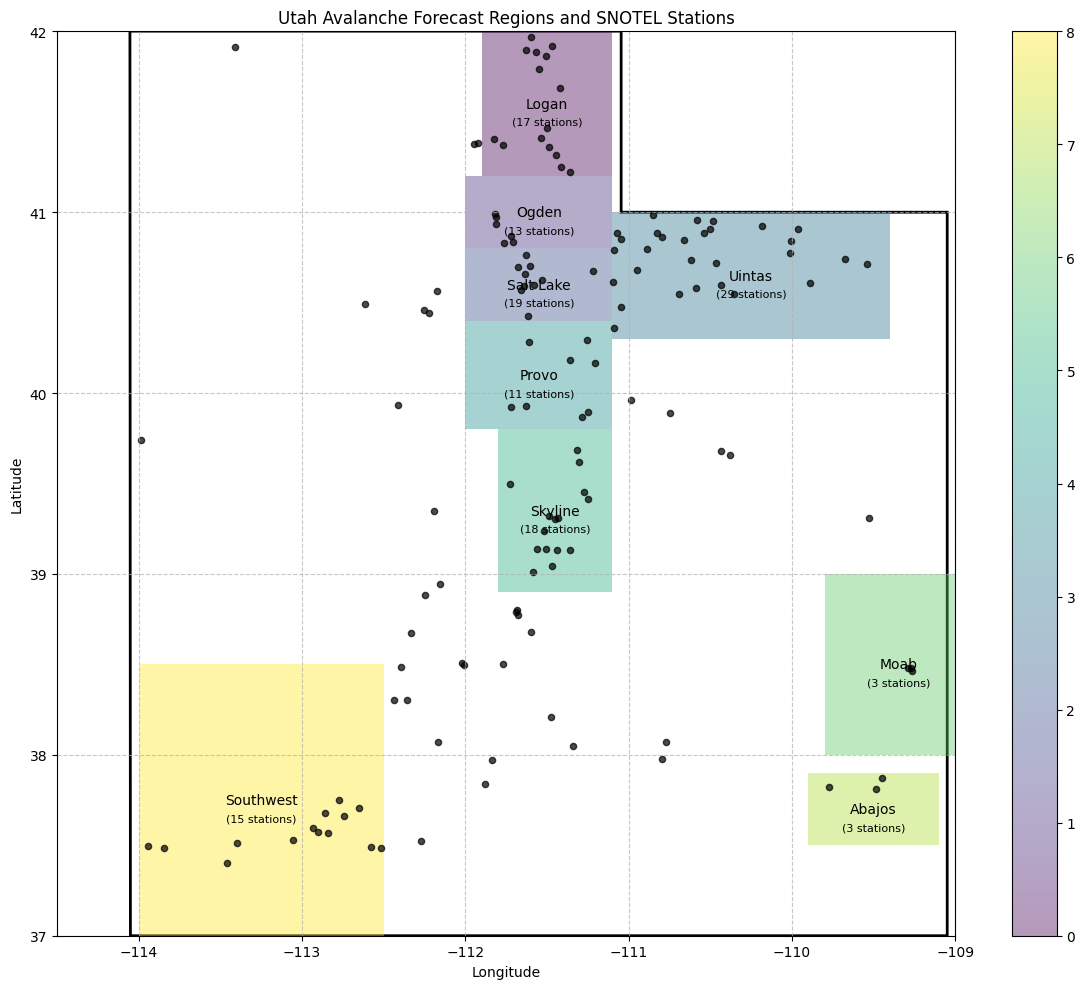

In [49]:
def visualize_regions(snotel_df, region_stations, region_boundaries):
    colors = list(mcolors.TABLEAU_COLORS)

    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)

    utah_boundary = [
        [42.001, -114.053],
        [42.001, -111.046],
        [41.000, -111.046],
        [41.000, -109.050],
        [37.000, -109.050],
        [37.000, -114.050],
        [42.001, -114.053],
    ]

    utah_coords = np.array(utah_boundary)[:, [1, 0]]
    utah_polygon = MplPolygon(utah_coords, closed=True, fill=False, edgecolor="black", linewidth=2)
    ax.add_patch(utah_polygon)

    patches, region_centroids = [], {}
    for coords in region_boundaries.values():
        patches.append(MplPolygon(np.array(coords)[:, [1, 0]], closed=True, fill=True))

    p = PatchCollection(patches, alpha=0.4)
    p.set_array(np.arange(len(patches)))
    ax.add_collection(p)
    plt.colorbar(p)

    for region_name, coords in region_boundaries.items():
        centroid_x = np.mean([p[1] for p in coords])
        centroid_y = np.mean([p[0] for p in coords])
        region_centroids[region_name] = (centroid_x, centroid_y)
        ax.text(centroid_x, centroid_y, region_name, fontsize=10, ha="center", va="center")

    ax.scatter(snotel_df["longitude"], snotel_df["latitude"], c="black", s=20, alpha=0.7, label="SNOTEL Stations")

    for region_name, (x, y) in region_centroids.items():
        ax.text(x, y - 0.1, f"({len(region_stations[region_name])} stations)", fontsize=8, ha="center", va="center")

    ax.set_xlim(-114.5, -109.0)
    ax.set_ylim(37.0, 42.0)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Utah Avalanche Forecast Regions and SNOTEL Stations")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


visualize_regions(snotel_df, region_stations, region_boundaries)

The boundaries are meant to closely match the map used by the [Utah Avalanche Center](https://utahavalanchecenter.org/). Because there are so few stations in the Abajos and Moab region, and their weather patterns differ significantly from the northern 6 regions, they will be ommited. The Southwest region is being ommited as there are no longer avalanche predictions for it.

In [50]:
regions = ["Logan", "Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]

In [51]:
def get_unique_station_ids(region_stations, regions):
    return list({st["stationId"] for reg in regions for st in region_stations[reg]})

unique_ids = get_unique_station_ids(region_stations, regions)
len(unique_ids)

86

### Explode Dataset to Cover Every Station in Every Region

In [52]:
# 1. Compute a list of regions for each station
snotel_df["regions"] = snotel_df.apply(
    lambda row: determine_region(row["latitude"], row["longitude"]),
    axis=1
)

# 2. (Optional) If you’d rather drop any stations that don’t fall in _any_ region:
snotel_df = snotel_df[snotel_df["regions"].map(len) > 0]

# 3. Explode the list of regions into one row per (station, region) pair
snotel_df = (
    snotel_df
    .explode("regions")
    .rename(columns={"regions": "Region"})
    .reset_index(drop=True)
)

snotel_df

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region
0,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775,2022-08-25 00:00,Salt Lake
1,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770,2010-10-28 00:00,Uintas
2,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813,1980-06-18 00:00,Skyline
3,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00,Salt Lake
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00,Uintas
...,...,...,...,...,...,...,...,...,...,...
123,1164,UT,SNTL,Wolf Creek Peak,Wasatch,9770.0,40.47733,-111.04469,2020-08-26 00:00,Provo
124,1164,UT,SNTL,Wolf Creek Peak,Wasatch,9770.0,40.47733,-111.04469,2020-08-26 00:00,Salt Lake
125,1164,UT,SNTL,Wolf Creek Peak,Wasatch,9770.0,40.47733,-111.04469,2020-08-26 00:00,Uintas
126,1228,UT,SNTL,Wrigley Creek,Sanpete,9330.0,39.13233,-111.35685,2012-10-01 00:00,Skyline


### Map Each Station to an Elevation Band

Elevation bands are from [Utah Avalanche Center](https://utahavalanchecenter.org/) that are used for their forecasts.

In [53]:
region_elevations = [
  {
    "region": "Logan",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Ogden",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Uintas",
    "elevation_levels": {
      "level_1": {"max": 9500, "min": 0},
      "level_2": {"max": 10000, "min": 9501},
      "level_3": {"max": 20000, "min": 10001}
    }
  },
  {
    "region": "Salt Lake",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Provo",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Skyline",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501
      }
    }
  }
]

In [54]:
elevation_lookup = {item["region"]: item["elevation_levels"] for item in region_elevations}

def get_elevation_level(elevation, region):
    levels = elevation_lookup.get(region)
    if not levels:
        return 0

    if elevation <= levels["level_1"]["max"]:
        return 1
    if elevation <= levels["level_2"]["max"]:
        return 2
    return 3

# compute elevation_level for each row
snotel_df["elevation_level"] = snotel_df.apply(
    lambda row: get_elevation_level(row["elevation"], row["Region"]),
    axis=1
)

counts = (
    snotel_df
    .groupby(["Region", "elevation_level"])
    .stationId
    .nunique()             # or .size() if you’re OK with counting duplicates
    .reset_index(name="count")
)

# print it as a table
print("Stations per region by elevation level:")
for region in counts["Region"].unique():
    sub = counts[counts["Region"] == region]
    print(f"\n{region}:")
    for _, row in sub.sort_values("elevation_level").iterrows():
        lvl = row["elevation_level"]
        cnt = row["count"]
        print(f"  Level {lvl}: {cnt} stations")


Stations per region by elevation level:

Abajos:
  Level 0: 3 stations

Logan:
  Level 1: 4 stations
  Level 2: 11 stations
  Level 3: 2 stations

Moab:
  Level 0: 3 stations

Ogden:
  Level 1: 3 stations
  Level 2: 9 stations
  Level 3: 1 stations

Provo:
  Level 1: 5 stations
  Level 2: 5 stations
  Level 3: 1 stations

Salt Lake:
  Level 1: 6 stations
  Level 2: 12 stations
  Level 3: 1 stations

Skyline:
  Level 1: 4 stations
  Level 2: 10 stations
  Level 3: 4 stations

Southwest:
  Level 0: 15 stations

Uintas:
  Level 1: 17 stations
  Level 2: 5 stations
  Level 3: 7 stations


## Fetch the Timeseries SNOTEL Data

In [55]:
snotel_elements = {
    "Snow_Depth": "SNWD",
    "SWE": "WTEQ",
    "Precipitation_Increment": "PRCP",
    "Snow_Density": "SNDN",
    "Avg_Temp": "TAVG",
    "Max_Temp": "TMAX",
    "Min_Temp": "TMIN",
    "Avg_Wind_Speed": "WSPDV",
    "Max_Wind_Speed": "WSPDX",
    "Avg_Wind_Direction": "WDIRV",
    "Max_Wind_Direction": "WDIRX",
    "Avg_Snow_Temperature": "SNTP",
    "Max_Snow_Temperature": "SNTX",
    "Min_Snow_Temperature": "SNTN",
    "Solar_Radiation": "SRADV",
    "Solar_Radiation_Max": "SRADX",
    "Relative_Humidity": "RHUMV",
    "Max_Relative_Humidity": "RHUMX",
    "Min_Relative_Humidity": "RHUMN",
}

In [56]:
def fetch_snotel_data(triplet, begin_date, end_date, elements):
    data_url = BASE_URL + "data"
    params = {
        "stationTriplets": triplet,
        "beginDate": begin_date,
        "endDate": end_date,
        "elements": ",".join(elements.values()),
        "duration": "DAILY",
    }
    for _ in range(2):
        try:
            resp = requests.get(data_url, params=params, timeout=60)
            if resp.ok:
                return resp.json()
        except Exception as e:
            print(f"Retrying {triplet} after error: {e}")
    print("Failed:", triplet)
    return []


def process_station_data(station_id, start_date, end_date, elements):
    triplet = f"{station_id}:UT:SNTL"
    series = []
    for site in fetch_snotel_data(triplet, start_date, end_date, elements):
        for element in site.get("data", []):
            code = element["stationElement"]["elementCode"]
            col = next(k for k, v in elements.items() if v == code)
            for val in element.get("values", []):
                rec = next((r for r in series if r["Date"] == val["date"]), None)
                if rec is None:
                    rec = {"Date": val["date"], "stationId": station_id}
                    series.append(rec)
                rec[col] = val.get("value")
    return series


def fetch_all_snotel_data( ids, elements, start_date, end_date=date.today().strftime("%Y-%m-%d"), max_workers=15,):
    total = len(ids)
    print(f"Fetching daily SNOTEL data for {total} stations…")

    all_rows = []
    done = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {
            ex.submit(process_station_data, sid, start_date, end_date, elements): sid
            for sid in ids
        }

        for fut in as_completed(futures):
            sid = futures[fut]
            try:
                all_rows.extend(fut.result())
            except Exception as e:
                # keep going, but show which station failed
                print(f"  ✖ {sid} → {e}")
            done += 1

            # Print progress every 10 stations or on the last one
            if done % 10 == 0 or done == total:
                print(f"  {done}/{total} stations complete ({done / total:.0%})")

    return pd.DataFrame(all_rows)



snotel_df_ts = fetch_all_snotel_data(unique_ids, snotel_elements, "2013-12-13")
snotel_df_ts.head()

Fetching daily SNOTEL data for 86 stations…
  10/86 stations complete (12%)
  20/86 stations complete (23%)
  30/86 stations complete (35%)
  40/86 stations complete (47%)
  50/86 stations complete (58%)
  60/86 stations complete (70%)
  70/86 stations complete (81%)
  80/86 stations complete (93%)
  86/86 stations complete (100%)


,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,2024-06-22,1321,0.0,0.0,63.3,80.4,48.9,0.0,NaN,NaN,NaN,NaN
1,2024-06-23,1321,0.0,0.0,67.3,84.7,51.4,0.0,NaN,NaN,NaN,NaN
2,2024-06-24,1321,0.0,0.0,65.8,81.3,53.6,0.0,NaN,NaN,NaN,NaN
3,2024-06-25,1321,0.0,0.0,66.6,83.7,55.2,0.0,NaN,NaN,NaN,NaN
4,2024-06-26,1321,0.0,0.0,63.9,79.7,54.5,0.0,NaN,NaN,NaN,NaN


### Look For Anomolies in the Data

In [57]:
snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,341801.000000,341878.000000,340434.000000,340459.000000,340374.000000,341884.000000,170542.000000,12741.000000,12737.000000,12737.000000
mean,0.086293,17.287369,39.155369,50.798576,28.644529,5.342880,29.428445,218.736441,5.013300,17.102842
std,0.215686,23.086151,16.237940,17.614966,15.810329,8.151401,9.052737,285.481407,3.847713,7.222232
min,0.000000,0.000000,-147.800000,-147.800000,-147.800000,0.000000,6.200000,-100.000000,-99.900000,-99.900000
25%,0.000000,0.000000,26.800000,36.900000,17.400000,0.000000,22.800000,140.000000,2.700000,12.200000
50%,0.000000,4.000000,37.900000,49.500000,28.800000,0.900000,27.800000,242.000000,3.400000,15.700000
75%,0.100000,31.000000,53.100000,65.800000,41.000000,8.400000,35.100000,284.000000,6.200000,21.000000
max,5.700000,229.000000,83.700000,132.100000,83.700000,82.800000,85.000000,18922.000000,26.100000,56.800000


In [58]:
snotel_df_ts[snotel_df_ts["Avg_Wind_Speed"] <= -99]

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
215485,2024-12-04,828,0.0,20.0,NaN,NaN,NaN,4.4,22.0,-100.0,-99.9,-99.9


There appears to be a bad wind reading at station 828 on 2024-12-04.

In [59]:
# Identify the rows you want to modify
mask = (snotel_df_ts["Avg_Wind_Speed"] <= -99)

# Set specific columns to NaN
snotel_df_ts.loc[mask, ["Avg_Wind_Direction", "Avg_Wind_Speed", "Max_Wind_Speed"]] = np.nan
snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,341801.000000,341878.000000,340434.000000,340459.000000,340374.000000,341884.000000,170542.000000,12740.000000,12736.000000,12736.000000
mean,0.086293,17.287369,39.155369,50.798576,28.644529,5.342880,29.428445,218.761460,5.021537,17.112029
std,0.215686,23.086151,16.237940,17.614966,15.810329,8.151401,9.052737,285.478644,3.733858,7.147704
min,0.000000,0.000000,-147.800000,-147.800000,-147.800000,0.000000,6.200000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,26.800000,36.900000,17.400000,0.000000,22.800000,140.000000,2.700000,12.200000
50%,0.000000,4.000000,37.900000,49.500000,28.800000,0.900000,27.800000,242.000000,3.400000,15.700000
75%,0.100000,31.000000,53.100000,65.800000,41.000000,8.400000,35.100000,284.000000,6.200000,21.000000
max,5.700000,229.000000,83.700000,132.100000,83.700000,82.800000,85.000000,18922.000000,26.100000,56.800000


In [60]:
len(snotel_df_ts)

341884

## Combine the Metadata with Time-series Data

In [135]:
snotel_dataset = (
    snotel_df_ts
    .merge(
        snotel_df,
        on=["stationId"],
        how="left",
    )
)
snotel_dataset.sort_values(['Region', 'Date', 'elevation_level']).head()

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,...,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region,elevation_level
311,2013-12-13,333,0.2,18.0,21.2,30.4,13.1,2.6,14.4,NaN,...,UT,SNTL,Ben Lomond Trail,Weber,5980.0,41.38291,-111.92103,1980-06-03 00:00,Logan,1
4466,2013-12-13,1118,0.0,4.0,15.3,29.5,7.0,1.1,27.5,NaN,...,UT,SNTL,Lost Creek Resv,Morgan,6070.0,41.22155,-111.35947,2010-10-01 00:00,Logan,1
238477,2013-12-13,1113,0.0,6.0,17.8,32.4,8.8,1.3,21.7,NaN,...,UT,SNTL,Tony Grove RS,Cache,6320.0,41.88573,-111.56918,2009-10-01 00:00,Logan,1
397217,2013-12-13,582,0.3,11.0,21.6,29.8,17.1,2.9,26.4,NaN,...,UT,SNTL,Little Bear,Cache,6540.0,41.40562,-111.82607,1978-10-01 00:00,Logan,1
16928,2013-12-13,1145,0.2,14.0,20.8,30.2,11.5,3.0,21.4,NaN,...,UT,SNTL,Kilfoil Creek,Morgan,7230.0,41.24764,-111.41249,2010-10-01 00:00,Logan,2


In [136]:
# DELETE THIS
snotel_dataset['Date'] = pd.to_datetime(snotel_dataset['Date'])

# define your mask
mask = (
    (snotel_dataset['Region'] == 'Ogden') &
    (snotel_dataset['Date'] >= '2013-12-13') &
    (snotel_dataset['Date'] <= '2013-12-20') &
    (snotel_dataset['elevation_level'] == 3)
)

snotel_dataset.loc[mask].sort_values(['Date','elevation_level'])


,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,...,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region,elevation_level
271710,2013-12-13,392,0.0,28.0,19.6,25.7,11.5,6.7,23.9,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271713,2013-12-14,392,0.0,28.0,19.9,28.8,10.9,6.7,23.9,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271716,2013-12-15,392,0.0,27.0,28.9,39.2,20.5,6.7,24.8,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271719,2013-12-16,392,0.0,27.0,30.4,39.2,24.1,6.7,24.8,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271722,2013-12-17,392,0.0,27.0,33.3,45.7,24.8,6.7,24.8,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271725,2013-12-18,392,0.0,27.0,35.4,43.3,30.7,6.7,24.8,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271728,2013-12-19,392,0.9,34.0,26.4,32.4,19.0,7.6,22.4,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3
271731,2013-12-20,392,0.0,34.0,14.7,20.1,10.6,7.6,22.4,NaN,...,UT,SNTL,Chalk Creek #1,Summit,9160.0,40.85464,-111.04765,1978-10-01 00:00,Ogden,3


In [137]:
len(snotel_dataset)

422141

### Which Regions have wind data?

In [138]:
snotel_dataset = snotel_dataset[snotel_dataset["Avg_Wind_Speed"] >= 0]

snotel_dataset["Region"].value_counts()

,count
Region,
Ogden,4448
Provo,4136
Skyline,4008
Salt Lake,2733
Uintas,144


In the SNOTEL dataset, there are only a few stations that provide wind data, but given that this is data is free and easily accessible, I will not supplement with data from other sources (I have considered and ruled out collecting data from sources like NOAA, MesoNet, ERA5).

Due to the limited data in the Uintas Region, and no data in the Logan Region I will ommit these two regions for the rest of my analysis.

In [139]:
regions = ["Ogden", "Salt Lake", "Provo", "Skyline"]

In [140]:
snotel_dataset = snotel_dataset[snotel_dataset['Region'].isin(regions)]
snotel_dataset["Region"].value_counts()

,count
Region,
Ogden,4448
Provo,4136
Skyline,4008
Salt Lake,2733


### Aggregate the Data For Each Region, Elevation Level, and Day

In [141]:
# Ensure Date is a datetime and sort
snotel_dataset.loc[:, 'Date'] = pd.to_datetime(snotel_dataset['Date'])
snotel_dataset = snotel_dataset.sort_values(['Region', 'elevation_level', 'Date'])
snotel_dataset.sort_values(['Region', 'Date', 'elevation_level']).head()


,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,...,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region,elevation_level
368140,2013-12-13,972,0.0,16.0,16.3,26.4,9.9,4.0,25.0,81.0,...,UT,SNTL,Louis Meadow,Salt Lake,6750.0,40.83033,-111.76457,1999-10-01 00:00,Ogden,1
368142,2013-12-14,972,0.0,15.0,18.3,27.1,8.6,4.0,26.7,62.0,...,UT,SNTL,Louis Meadow,Salt Lake,6750.0,40.83033,-111.76457,1999-10-01 00:00,Ogden,1
368144,2013-12-15,972,0.1,15.0,18.7,26.4,12.7,4.1,27.3,94.0,...,UT,SNTL,Louis Meadow,Salt Lake,6750.0,40.83033,-111.76457,1999-10-01 00:00,Ogden,1
368146,2013-12-16,972,0.0,15.0,23.0,28.8,18.3,4.1,27.3,88.0,...,UT,SNTL,Louis Meadow,Salt Lake,6750.0,40.83033,-111.76457,1999-10-01 00:00,Ogden,1
368148,2013-12-17,972,0.0,15.0,25.2,30.0,19.8,4.1,27.3,92.0,...,UT,SNTL,Louis Meadow,Salt Lake,6750.0,40.83033,-111.76457,1999-10-01 00:00,Ogden,1


In [142]:
# Define which columns to aggregate and how
agg_map = {
    'Precipitation_Increment': 'max',
    'Snow_Depth':            'max',
    'SWE':                   'max',
    'Avg_Temp':              'mean',
    'Max_Temp':              'max',
    'Min_Temp':              'min',
    'Snow_Density':          'mean',
    'Avg_Wind_Direction':    'max', # while not ideal, there are not multiple stations in any of the regions but max w
    'Avg_Wind_Speed':        'mean',
    'Max_Wind_Speed':        'max'
}

# Perform the aggregation
snotel_dataset_agg = (
    snotel_dataset
    .groupby(['Region', 'Date', 'elevation_level'], as_index=False)
    .agg(agg_map)
)

snotel_dataset_agg.sort_values(['Region', 'Date', 'elevation_level']).head()

,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,Ogden,2013-12-13,1,0.0,16.0,4.0,16.3,26.4,9.9,25.0,81.0,2.3,9.3
1,Ogden,2013-12-14,1,0.0,15.0,4.0,18.3,27.1,8.6,26.7,62.0,2.0,7.8
2,Ogden,2013-12-15,1,0.1,15.0,4.1,18.7,26.4,12.7,27.3,94.0,3.0,6.0
3,Ogden,2013-12-16,1,0.0,15.0,4.1,23.0,28.8,18.3,27.3,88.0,3.6,5.5
4,Ogden,2013-12-17,1,0.0,15.0,4.1,25.2,30.0,19.8,27.3,92.0,3.8,6.7


### Fill NaN Values

In [143]:
def fill_missing_by_elevation_vectorized(df: pd.DataFrame, data_cols: list) -> pd.DataFrame:
    """
    Vectorized fill of NaNs within each (Region, Date) across elevation_level 1,2,3:
      1. Pivot to wide form with elevation_level as columns.
      2. For each data column:
         - Compute mean of levels 1 & 3 (skipna=True) to derive level 2 where missing.
         - Fill level 2 with that mean.
         - Propagate level 2 values to levels 1 & 3 where they are NaN.
      3. Stack back to long form.
    All assignments use .loc or direct column assignment to avoid chained-assignment.
    """
    idx = ['Region', 'Date']
    # pivot to wide: MultiIndex columns (data_col, elevation_level)
    df_wide = df.pivot(index=idx, columns='elevation_level', values=data_cols)

    for col in data_cols:
        # pull the three series
        s1 = df_wide[(col, 1)]
        s2 = df_wide[(col, 2)]
        s3 = df_wide[(col, 3)]

        # compute mean of level 1 & 3 where at least one is present
        mean13 = pd.concat([s1, s3], axis=1).mean(axis=1)

        # Fill s2 where it's NaN
        filled_s2 = s2.fillna(mean13)

        # Assign back in one shot
        df_wide.loc[:, (col, 2)] = filled_s2

        # Propagate to 1 & 3 in one shot
        df_wide.loc[:, (col, 1)] = s1.fillna(filled_s2)
        df_wide.loc[:, (col, 3)] = s3.fillna(filled_s2)

    # Stack elevation_level back into a column
    df_filled = (
        df_wide
        .stack(level='elevation_level')  # now columns are data_cols again
        .reset_index()
    )

    return df_filled


weather_cols = [
    'Precipitation_Increment', 'Snow_Depth', 'SWE',
    'Avg_Temp', 'Max_Temp', 'Min_Temp',
    'Snow_Density', 'Avg_Wind_Direction',
    'Avg_Wind_Speed', 'Max_Wind_Speed'
]

# Apply to your aggregated DataFrame:
snotel_dataset_agg_full = fill_missing_by_elevation_vectorized(
    snotel_dataset_agg,
    weather_cols
)

snotel_dataset_agg_full.sort_values(['Region', 'Date', 'elevation_level']).head()


<ipython-input-143-838c0f53b4d1>:38: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level='elevation_level')  # now columns are data_cols again


,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,Ogden,2013-12-13,1,0.0,16.0,4.0,16.3,26.4,9.9,25.0,81.0,2.3,9.3
1,Ogden,2013-12-13,2,0.0,16.0,4.0,16.3,26.4,9.9,25.0,81.0,2.3,9.3
2,Ogden,2013-12-13,3,0.0,16.0,4.0,16.3,26.4,9.9,25.0,81.0,2.3,9.3
3,Ogden,2013-12-14,1,0.0,15.0,4.0,18.3,27.1,8.6,26.7,62.0,2.0,7.8
4,Ogden,2013-12-14,2,0.0,15.0,4.0,18.3,27.1,8.6,26.7,62.0,2.0,7.8


In [144]:
nan_mask = snotel_dataset_agg_full[weather_cols].isna().any(axis=1)
snotel_dataset_agg_full[nan_mask].sort_values(['Region', 'Date', 'elevation_level'])

,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
381,Ogden,2014-04-20,1,0.0,1.0,0.6,45.0,57.9,34.0,NaN,112.0,3.2,11.9
382,Ogden,2014-04-20,2,0.0,1.0,0.6,45.0,57.9,34.0,NaN,112.0,3.2,11.9
383,Ogden,2014-04-20,3,0.0,1.0,0.6,45.0,57.9,34.0,NaN,112.0,3.2,11.9
384,Ogden,2014-04-21,1,0.0,0.0,0.0,46.8,63.5,32.7,NaN,105.0,3.4,11.6
385,Ogden,2014-04-21,2,0.0,0.0,0.0,46.8,63.5,32.7,NaN,105.0,3.4,11.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44566,Skyline,2024-11-05,2,0.2,5.0,0.8,19.2,25.7,12.7,NaN,298.0,10.1,21.0
44567,Skyline,2024-11-05,3,0.2,5.0,0.8,19.2,25.7,12.7,NaN,298.0,10.1,21.0
45027,Skyline,2025-04-08,1,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1
45028,Skyline,2025-04-08,2,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1


There are still many columns with NaN values that need to be eliminated before the data can be fed into the model.

In [145]:
nan_mask_not_sd = snotel_dataset_agg_full[weather_cols].drop(columns='Snow_Density').isna().any(axis=1)
snotel_dataset_agg_full[nan_mask_not_sd].sort_values(['Region', 'Date', 'elevation_level'])

,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
39786,Skyline,2020-02-03,1,0.0,33.0,9.1,NaN,28.9,0.0,27.6,283.0,16.3,39.4
39787,Skyline,2020-02-03,2,0.0,33.0,9.1,NaN,28.9,0.0,27.6,283.0,16.3,39.4
39788,Skyline,2020-02-03,3,0.0,33.0,9.1,NaN,28.9,0.0,27.6,283.0,16.3,39.4
40440,Skyline,2020-09-08,1,0.3,0.0,0.0,NaN,43.3,24.4,NaN,319.0,11.3,26.8
40441,Skyline,2020-09-08,2,0.3,0.0,0.0,NaN,43.3,24.4,NaN,319.0,11.3,26.8
40442,Skyline,2020-09-08,3,0.3,0.0,0.0,NaN,43.3,24.4,NaN,319.0,11.3,26.8
45027,Skyline,2025-04-08,1,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1
45028,Skyline,2025-04-08,2,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1
45029,Skyline,2025-04-08,3,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1


Many of the NaN values are in the `Snow_Density` column so it will be manually computed where it is missing using `Snow_Depth` and `SWE` (snow water equivilent).

In [148]:
mask_missing = snotel_dataset_agg_full['Snow_Density'].isna()

# of those rows where either SWE or Snow_Depth is zero, density = 0
mask_zero = mask_missing & (
    (snotel_dataset_agg_full['SWE'] == 0) |
    (snotel_dataset_agg_full['Snow_Depth'] == 0)
)
snotel_dataset_agg_full.loc[mask_zero, 'Snow_Density'] = 0

# of the remaining missing rows where both SWE and depth are non-zero, compute ratio
mask_compute = mask_missing & (
    snotel_dataset_agg_full['SWE'].notna() &
    snotel_dataset_agg_full['Snow_Depth'].notna() &
    (snotel_dataset_agg_full['Snow_Depth'] != 0) &
    (snotel_dataset_agg_full['SWE'] != 0)
)
snotel_dataset_agg_full.loc[mask_compute, 'Snow_Density'] = (
    snotel_dataset_agg_full.loc[mask_compute, 'SWE']
    / snotel_dataset_agg_full.loc[mask_compute, 'Snow_Depth']
)

new_fill_mask = mask_zero | mask_compute
snotel_dataset_agg_full.loc[new_fill_mask].head()


,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
384,Ogden,2014-04-21,1,0.0,0.0,0.0,46.8,63.5,32.7,0.0,105.0,3.4,11.6
385,Ogden,2014-04-21,2,0.0,0.0,0.0,46.8,63.5,32.7,0.0,105.0,3.4,11.6
386,Ogden,2014-04-21,3,0.0,0.0,0.0,46.8,63.5,32.7,0.0,105.0,3.4,11.6
387,Ogden,2014-04-22,1,0.3,0.0,0.0,45.7,60.8,28.8,0.0,137.0,3.3,26.5
388,Ogden,2014-04-22,2,0.3,0.0,0.0,45.7,60.8,28.8,0.0,137.0,3.3,26.5


In [149]:
nan_mask = snotel_dataset_agg_full[weather_cols].isna().any(axis=1)
snotel_dataset_agg_full[nan_mask].sort_values(['Region', 'Date', 'elevation_level'])

,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
39786,Skyline,2020-02-03,1,0.0,33.0,9.1,NaN,28.9,0.0,27.6,283.0,16.3,39.4
39787,Skyline,2020-02-03,2,0.0,33.0,9.1,NaN,28.9,0.0,27.6,283.0,16.3,39.4
39788,Skyline,2020-02-03,3,0.0,33.0,9.1,NaN,28.9,0.0,27.6,283.0,16.3,39.4
40440,Skyline,2020-09-08,1,0.3,0.0,0.0,NaN,43.3,24.4,0.0,319.0,11.3,26.8
40441,Skyline,2020-09-08,2,0.3,0.0,0.0,NaN,43.3,24.4,0.0,319.0,11.3,26.8
40442,Skyline,2020-09-08,3,0.3,0.0,0.0,NaN,43.3,24.4,0.0,319.0,11.3,26.8
45027,Skyline,2025-04-08,1,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1
45028,Skyline,2025-04-08,2,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1
45029,Skyline,2025-04-08,3,0.0,32.0,10.8,NaN,NaN,NaN,33.8,282.0,10.8,19.1


The remaining NaN values are in temperature. Since some do have a max/min temperature, an average will be computed.

In [150]:
mask_avg_fill = (
    snotel_dataset_agg_full['Avg_Temp'].isna() &
    snotel_dataset_agg_full['Max_Temp'].notna() &
    snotel_dataset_agg_full['Min_Temp'].notna()
)

snotel_dataset_agg_full.loc[mask_avg_fill, 'Avg_Temp'] = (
    snotel_dataset_agg_full.loc[mask_avg_fill, 'Max_Temp'] +
    snotel_dataset_agg_full.loc[mask_avg_fill, 'Min_Temp']
) / 2

snotel_dataset_agg_full.loc[mask_avg_fill].head()


,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
39786,Skyline,2020-02-03,1,0.0,33.0,9.1,14.45,28.9,0.0,27.6,283.0,16.3,39.4
39787,Skyline,2020-02-03,2,0.0,33.0,9.1,14.45,28.9,0.0,27.6,283.0,16.3,39.4
39788,Skyline,2020-02-03,3,0.0,33.0,9.1,14.45,28.9,0.0,27.6,283.0,16.3,39.4
40440,Skyline,2020-09-08,1,0.3,0.0,0.0,33.85,43.3,24.4,0.0,319.0,11.3,26.8
40441,Skyline,2020-09-08,2,0.3,0.0,0.0,33.85,43.3,24.4,0.0,319.0,11.3,26.8


The remaining NaN values will be forward filled.

In [151]:
# sort the data
snotel_dataset_agg_full.sort_values(
    ['Region', 'elevation_level', 'Date'],
    inplace=True
)

# forward‐fill within each Region / elevation_level group
snotel_dataset_agg_full = (
    snotel_dataset_agg_full
    .groupby(['Region', 'elevation_level'], group_keys=False)
    .apply(lambda grp: grp.ffill())
    .reset_index(drop=True)
)

# 3) Quick check for any remaining NaNs
snotel_dataset_agg_full.isna().any()

<ipython-input-151-faefe9f1aeb3>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.ffill())


,0
Region,False
Date,False
elevation_level,False
Precipitation_Increment,False
Snow_Depth,False
SWE,False
Avg_Temp,False
Max_Temp,False
Min_Temp,False
Snow_Density,False


In [152]:
snotel_dataset_agg.to_csv("snotel_dataset_agg.csv", index=False)

In [153]:
snotel_dataset_agg = pd.read_csv("snotel_dataset_agg.csv")

## Read Avalanch Forecast Dataset

In [124]:
avy_forecast_df = pd.read_csv("avalanche-forecast-rose.csv")
avy_forecast_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'avalanche-forecast-rose.csv'

In [ ]:
avy_forecast_df = avy_forecast_df.rename(columns={"Forecast Area": "Region", "Date Issued": "Date"})
avy_forecast_df.head()

In [ ]:
# Drop unused regions
avy_forecast_df = avy_forecast_df[avy_forecast_df["Region"].isin(regions)]
set(avy_forecast_df['Region'])

In [ ]:
avy_forecast_df.loc[:, "Date"] = pd.to_datetime(avy_forecast_df["Date"])


In [ ]:
id_cols = ['Date', 'Region']
level_codes = {'lower': 1, 'middle': 2, 'upper': 3}


In [ ]:
pieces = []
for lvl in level_codes:
    # find all columns that end with "-<lvl>"
    lvl_cols = [c for c in avy_forecast_df.columns if c.endswith(f'-{lvl}')]
    # select id_cols + those columns
    sub = avy_forecast_df[id_cols + lvl_cols].copy()
    # rename e.g. "North-lower" → "North"
    rename_map = {c: c.rsplit('-', 1)[0] for c in lvl_cols}
    sub = sub.rename(columns=rename_map)
    # tag the numeric elevation_level
    sub['elevation_level'] = level_codes[lvl]
    pieces.append(sub)

# 5) Concatenate back into one “long” DataFrame
avy_forecast_long = pd.concat(pieces, ignore_index=True)
avy_forecast_long.head()

In [ ]:
avy_forecast_long.to_csv("avy_forecast_long.csv", index=False)

In [ ]:
avy_forecast_long['Date'] = pd.to_datetime(avy_forecast_long['Date']).dt.normalize()
snotel_dataset_agg['Date'] = pd.to_datetime(snotel_dataset_agg['Date']).dt.normalize()

In [ ]:
combined_df = pd.merge(avy_forecast_long, snotel_dataset_agg, on=["Date","Region","elevation_level"], how="left")
combined_df.sort_values(["Date", "elevation_level", "Region"], inplace=True)
combined_df.head()

In [ ]:
combined_df[combined_df[to_fill].isna().any(axis=1)]

## Create a Transformer

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)  # e.g. 3 folds
for fold, (train_index, val_index) in enumerate(tscv.split(final_df), 1):
    train_df = final_df.iloc[train_index]
    val_df   = final_df.iloc[val_index]
    print(f"Fold {fold}: train up to {train_df.Date.max()}, validate up to {val_df.Date.max()}")


In [ ]:
import torch

X_train = torch.from_numpy(train_df[weather_features].values).float()
Y_train = torch.from_numpy(train_df[target_cols].values).long()  # or float()

from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

X_tensor = torch.tensor(X.values, dtype=torch.float32)    # (N, F)
Y_tensor = torch.tensor(Y.values, dtype=torch.long)       # (N, 24)
ds = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(ds, batch_size=32, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, 24, d_model)

    def forward(self, x):
        # x: (batch, 24, d_model)
        return x + self.pe

class ForecastTransformer(nn.Module):
    def __init__(self, feature_dim, token_embed_dim=64, n_heads=4, n_layers=2, num_classes=5):
        super().__init__()
        # learnable embedding for each of the 24 positions (aspect × elevation)
        self.token_emb = nn.Embedding(24, token_embed_dim)
        # project global features into same dim
        self.feature_proj = nn.Linear(feature_dim, token_embed_dim)
        # positional encoding
        self.pos_enc = PositionalEncoding(token_embed_dim, max_len=24)
        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=token_embed_dim,
            nhead=n_heads,
            dim_feedforward=token_embed_dim * 4,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        # classification head per token
        self.classifier = nn.Linear(token_embed_dim, num_classes)

    def forward(self, features):
        """
        features: (batch, feature_dim)
        returns logits of shape (batch, 24, num_classes)
        """
        bsz = features.size(0)
        # repeat feature vector for each of the 24 tokens
        feat = self.feature_proj(features).unsqueeze(1).repeat(1, 24, 1)  # (b,24,d)
        # token embeddings
        token_ids = torch.arange(24, device=features.device).unsqueeze(0).repeat(bsz,1)
        tok = self.token_emb(token_ids)                                   # (b,24,d)
        x = feat + tok
        x = self.pos_enc(x)                                               # (b,24,d)
        # transformer expects (seq, batch, dim)
        x = x.transpose(0,1)                                              # (24,b, d)
        x = self.transformer(x)                                           # (24,b, d)
        x = x.transpose(0,1)                                              # (b,24,d)
        return self.classifier(x)                                         # (b,24,num_classes)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ForecastTransformer(feature_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 51):
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)                  # (b,24,5)
        # reshape for loss: combine batch & tokens dims
        loss = criterion(logits.view(-1,5),     # (b*24,5)
                         Y_batch.view(-1))      # (b*24)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} — loss {total_loss/len(loader):.4f}")
